In [90]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [91]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
townships = gpd.read_file('townships.geojson')
sales.rename(columns={'township_code': 'township'}, inplace=True)
sales.year = sales.year.astype(int)
#sales.township = sales.township.astype(int)
#townships.township = townships.township.astype(int)

town_sales = sales.merge(townships, on='township')

In [92]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

outliers = sales[sales.groupby('township')['sale_price_log10'].apply(is_outlier)]

<AxesSubplot:ylabel='Frequency'>

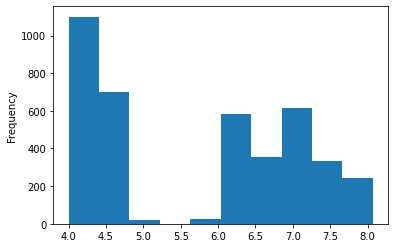

In [93]:
outliers.sale_price_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

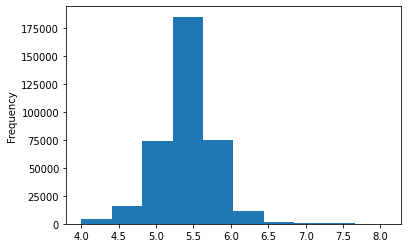

In [94]:
sales.sale_price_log10.plot.hist()